# 3. Create neural network

In [1]:
import os
import glob
import nibabel as nib
import numpy as np
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms


class NiftiDataset(Dataset):
    def __init__(self, source_dir, target_dir, transforms=None):
        """
        Args:
            source_dir (string): Directory with all source Nifti images (T1)
            target_folder (string): Directory with all target Nifti images (T2)
            transform(callable, optional): Optinal transform to be applied on a sample
        """
        
        source_filenames = glob.glob(os.path.join(source_dir, '*.nii.gz'))
        target_filenames = glob.glob(os.path.join(target_dir, '*.nii.gz'))
        
        assert len(source_filenames)==len(target_filenames)
        # Here we simply assumed that pairs of images are in the same order when 
        #   sorted alphabetically
        # Works here, but probably need to match filename patterns with regexp
        # Or check dimensions, etc
        
        self.pairs = list(zip(source_filenames, target_filenames))
        self.transforms = transforms

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        img_names = self.pairs[idx]
        source_image = nib.load(img_names[0])
        target_image = nib.load(img_names[1])
        sample = {'source': source_image, 'target': target_image}

        # Do transforms on original Nibabel objects
        if self.transforms:
            sample = self.transforms(sample)
        
        return sample


class ToNumpy:
    """Convert Nibabel object in sample to ndarrays."""
    def __call__(self, sample):
        return {'source': sample['source'].get_fdata(),
                'target': sample['target'].get_fdata()}
        

class ToTensor:
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        return {'source': torch.from_numpy(sample['source'].get_fdata()),
                'target': torch.from_numpy(sample['target'].get_fdata())}
    

class RandomCrop3D:
    def __init__(self, size):
        """
        Args:
            size: integer or tuple of three numbers 
                    (x,y,z) to crop 3D images to
        """
        assert isinstance(size, (int,tuple))
        if isinstance(size, int):
            self.size = (size, size, size)
        else:
            assert len(size) == 3
            self.size = size

    def __call__(self, sample):
        """
        Utilize Nibabel's image slicing to save memory
        Note: That will prevent call from working directly
        Reference: https://nipy.org/nibabel/nibabel_images.html#image-slicing
        """
        source_image, target_image = sample['source'], sample['target']
        
        dim_x, dim_y, dim_z = source_image.shape[:3]
        new_dim_x, new_dim_y, new_dim_z = self.size
        
        # Generate random offset such that cropped image fits inside original one
        offset_x = np.random.randint(0, dim_x - new_dim_x)
        offset_y = np.random.randint(0, dim_y - new_dim_y)
        offset_z = np.random.randint(0, dim_z - new_dim_z)
        
        return {'source': source_image.slicer[offset_x: offset_x+new_dim_x,
                                              offset_y: offset_y+new_dim_y,
                                              offset_z: offset_z+new_dim_z],
                'target': target_image.slicer[offset_x: offset_x+new_dim_x,
                                              offset_y: offset_y+new_dim_y,
                                              offset_z: offset_z+new_dim_z]}

### Create transformed Dataset with `RandomCrop3D` transformation

In [2]:
transformed_brain_dataset = NiftiDataset(source_dir='small/t1', 
                                         target_dir='small/t2', 
                                         transforms=transforms.Compose(
                                             [RandomCrop3D((30,30,30)), 
                                              ToTensor()])
                                        )

In [3]:
sample = transformed_brain_dataset[0]

In [4]:
sample['source'].shape

torch.Size([30, 30, 30])

In [5]:
sample['target'].shape

torch.Size([30, 30, 30])

### Define NN class

In [135]:
from torch import nn

class ConvNet(nn.Module):
    def __init__(self):
        # Define layers
        super().__init__()
        # 3D convolution layer
        # @params
        #   in_channels (int) – Number of channels in the input image
        #   out_channels (int) – Number of channels produced by the convolution
        #   kernel_size (int or tuple) – Size of the convolving kernel
        
        self.conv = nn.Conv3d(1, 36, kernel_size=3, padding=1)
        
    # x represents our data
    def forward(self, x):
        # Apply encoder layer
        x = self.conv(x)
        
        return x

At a minimum, the arguments we provide to nn.Conv3d are the number of input features (or channels, since we're dealing with so-called multi-channel images, i.e. more than one value per pixel), the number of output features, and the size of the kernel. For instance, for our first convolutional module we'll have 1 input feature per pixel (only the intensity channel) and an arbitrary number of channels in output, say 36. The more channels in the output image, the more the capacity of the network. Let’s stick to a kernel size of 3x3x3.

In [136]:
my_nn = ConvNet()

In [137]:
my_nn

ConvNet(
  (conv): Conv3d(1, 36, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
)

In [138]:
result = my_nn(sample['source'].float().unsqueeze(0).unsqueeze(0))

In [139]:
result[0][0].shape

torch.Size([30, 30, 30])

### Display convoluted result

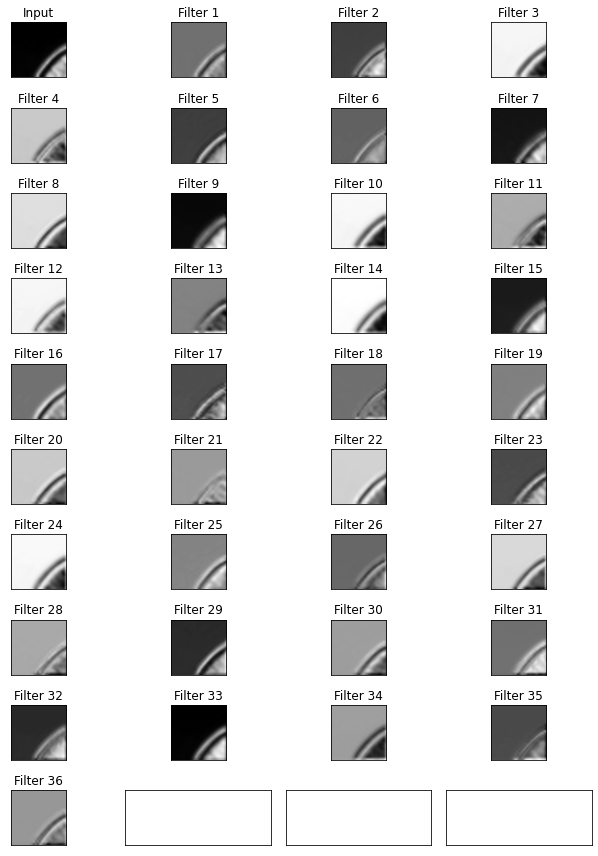

In [140]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Slice index
sl = 15   #Range: 0-30
n_filters = result[0].shape[0]


fig, axs = plt.subplots(nrows=(n_filters+1)//4+1, ncols=4, figsize=(9, 12), subplot_kw={'xticks': [], 'yticks': []})

axs.flat[0].set_title(f'Input')
axs.flat[0].imshow(sample['source'][:,sl,:], cmap="gist_gray", interpolation="bicubic")

for f in range(n_filters):
    s = result[0][f].detach().numpy()
    ax = axs.flat[f+1]
    ax.set_title(f'Filter {f+1}')
    ax.imshow(s[:,sl-1,:], cmap="gist_gray", interpolation="bicubic")

plt.tight_layout()
plt.show()

In [141]:
# Check values for conv filters weights and biases

In [142]:
my_nn.conv.weight[0]

tensor([[[[-0.0242, -0.1543, -0.1679],
          [-0.1773,  0.1778,  0.0683],
          [-0.0382, -0.1791,  0.1884]],

         [[ 0.1513,  0.0276,  0.0958],
          [ 0.1161,  0.0347,  0.0252],
          [-0.0192, -0.1256,  0.0399]],

         [[-0.0573, -0.0097, -0.1277],
          [ 0.1380,  0.1135,  0.0174],
          [-0.1439, -0.1049,  0.1843]]]], grad_fn=<SelectBackward>)

In [144]:
my_nn.conv.bias[0]

tensor(-0.1622, grad_fn=<SelectBackward>)

## Implement Convolutional Autoencoder

Now that we added convolutional layer and checked how it works, we can build the rest of network. I wanted to check if convolutional autoencoder would be a good architecture for this problem. On the surface it seem to do the job: recognize higher level features and filter the noise. Let's see how it does after training.

In [145]:
class ConvAutoEnc(nn.Module):
    def __init__(self):
        # Define layers
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(1, 36, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm3d(36),
            nn.MaxPool3d(kernel_size=2, stride=2, return_indices=True)
        )
    
        self.unp = nn.MaxUnpool3d(kernel_size=2, stride=2)
        
        self.dec = nn.Sequential(
            nn.ConvTranspose3d(36, 1, kernel_size=3, padding=1)
        )
        
    def forward(self, x):
        # Apply encoder layer
        x, indices = self.enc(x)
        
        # Apply unpool layer
        x = self.unp(x, indices)
        
        # Apply decode layer
        x = self.dec(x)
        
        return x

In [147]:
convEncNet = ConvAutoEnc()

In [148]:
convEncNet

ConvAutoEnc(
  (enc): Sequential(
    (0): Conv3d(1, 36, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): BatchNorm3d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool3d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (unp): MaxUnpool3d(kernel_size=(2, 2, 2), stride=(2, 2, 2), padding=(0, 0, 0))
  (dec): Sequential(
    (0): ConvTranspose3d(36, 1, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
)

In [149]:
result = convEncNet(sample['source'].float().unsqueeze(0).unsqueeze(0))

In [150]:
result.shape

torch.Size([1, 1, 30, 30, 30])

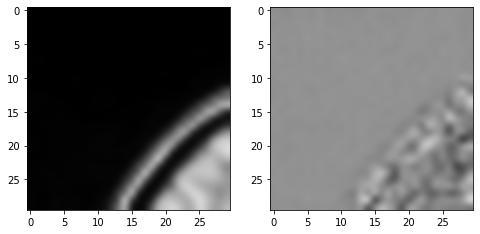

In [151]:
# Slice index
sl = 15   #Range: 0-119

fig=plt.figure(figsize=(8, 8))

fig.add_subplot(1, 2, 1)
plt.imshow(sample['source'][:,sl,:], cmap="gist_gray", interpolation="bicubic")

s = result[0][0].detach().numpy()
fig.add_subplot(1, 2, 2)
plt.imshow(s[:,sl,:], cmap="gist_gray", interpolation="bicubic")
    
plt.show()